<a href="https://colab.research.google.com/github/gerfx/predict_next_location/blob/main/predict_next_location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam



def round_coordinates(latitude, longitude, precision=2):
    """
    Округляет координаты до указанной точности.
    """
    return round(latitude, precision), round(longitude, precision)

def load_geolife_data(data_folder):
    """
    Загружает данные Geolife Trajectories из указанной папки.
    """
    all_data = pd.DataFrame()
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith(".plt"):
                file_path = os.path.join(root, file)
                data = pd.read_csv(file_path, skiprows=6, header=None)
                data.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
                data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
                data.drop(columns=['0', 'Date', 'Time'], inplace=True)
                data['Timestamp'] = pd.to_datetime(data['Timestamp'])
                data
                data.set_index('Timestamp', inplace=True)
                # Ресэмплирование данных: например, можно взять среднее каждые 1 минуту
                data = data.resample('20T').mean()  # 'T' означает минуту
                all_data = pd.concat([all_data, data], ignore_index=True)
    return all_data

def preprocess_data(data):
    """
    Предобрабатывает данные для обучения модели.
    """
    label_encoder = LabelEncoder()
    data['Class'] = data['Class'].apply(lambda x: str(x))
    data['Class'] = label_encoder.fit_transform(data['Class'])

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['Latitude', 'Longitude', 'NumDays']])
    scaled_data_df = pd.DataFrame(scaled_data, columns=['Latitude', 'Longitude', 'NumDays'])
    scaled_data_df['Class'] = data['Class']
    scaled_data_df = scaled_data_df.drop_duplicates(subset=['Class'])
    return scaled_data_df

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length - 1):
        seq_X = data[i:i + sequence_length][['Latitude', 'Longitude', 'NumDays']].values
        seq_y = data.iloc[i + sequence_length + 1][['Latitude', 'Longitude', 'NumDays']].values
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)


def split_train_test_data(data, test_size=0.2):
    train_size = int(len(data) * (1 - test_size))
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data



In [ ]:
# Загрузка данных
file_path = "/content/drive/MyDrive/Colab Notebooks/trajectory_data/Geolife Trajectories 1.3/111"
orig_data = load_geolife_data(file_path)
sequence_length = 35  # Длина последовательности

In [ ]:
orig_data

,Latitude,Longitude,Altitude,NumDays
0,40.002234,116.323367,318.300000,39784.303916
1,40.000560,116.325290,417.500000,39784.305596
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
6432,39.872622,116.369271,124.987480,39893.172786
6433,39.863108,116.395502,108.462626,39893.189708
6434,39.189626,117.187173,25.975806,39893.207526
6435,39.139910,117.202579,18.129032,39893.214205


In [ ]:
orig_data.fillna(method='bfill', inplace=True)


In [ ]:
print(orig_data)

       Latitude   Longitude    Altitude       NumDays
0     40.002234  116.323367  318.300000  39784.303916
1     40.000560  116.325290  417.500000  39784.305596
2     40.008248  116.322266  492.000000  39784.452448
3     40.008248  116.322266  492.000000  39784.452448
4     40.008248  116.322266  492.000000  39784.452448
...         ...         ...         ...           ...
6432  39.872622  116.369271  124.987480  39893.172786
6433  39.863108  116.395502  108.462626  39893.189708
6434  39.189626  117.187173   25.975806  39893.207526
6435  39.139910  117.202579   18.129032  39893.214205
6436  39.133371  117.213288  -59.724409  39893.230114

[6437 rows x 4 columns]


In [ ]:
def create_model(input_shape):
    """
    Создает и компилирует LSTM модель.
    """
    # model = Sequential([
    #     LSTM(units=64, input_shape=input_shape, return_sequences=True),
    #     Dropout(0.2),
    #     LSTM(units=64, return_sequences=False),
    #     Dropout(0.2),
    #     Dense(units=100, activation='relu'),  # Промежуточный Dense слой для повышения сложности модели
    #     Dense(units=3, activation='softmax')  # Выходной слой для классификации
    # ])
    model = Sequential([
        # LSTM(units=64, input_shape=input_shape, return_sequences=True),
        # Dropout(0.2),
        LSTM(units=64, return_sequences=False),
        Dropout(0.2),
        Dense(units=16),  # Промежуточный Dense слой для повышения сложности модели
        Dense(units=3)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


In [ ]:
# data = preprocess_data(orig_data)
train_data, test_data = split_train_test_data(orig_data)

# Создание последовательностей для обучения


In [ ]:
train_data, test_data

(       Latitude   Longitude  Altitude       NumDays
 0     40.002234  116.323367     318.3  39784.303916
 1     40.000560  116.325290     417.5  39784.305596
 2     40.008248  116.322266     492.0  39784.452448
 3     40.008248  116.322266     492.0  39784.452448
 4     40.008248  116.322266     492.0  39784.452448
 ...         ...         ...       ...           ...
 5144  40.443676   96.843680    -777.0  39537.562375
 5145  40.570146   96.633239    -777.0  39537.576211
 5146  40.662027   96.467477    -777.0  39537.590276
 5147  40.751652   96.286617    -777.0  39537.604337
 5148  40.866201   96.035041    -777.0  39537.618059
 
 [5149 rows x 4 columns],
        Latitude   Longitude    Altitude       NumDays
 5149  41.008678   95.778923 -777.000000  39537.631780
 5150  41.075221   95.557082 -777.000000  39537.645844
 5151  41.109531   95.499117 -777.000000  39537.659956
 5152  39.115386  117.186937  199.709497  39627.675900
 5153  39.123907  117.213002  -28.636132  39627.683080
 ...  

In [ ]:
# from sklearn.feature_selection import SelectKBest, f_classif
# import matplotlib.pyplot as plt
# import numpy as np

# def select_features(data, k=3):
#     """
#     Selects the most important features using the SelectKBest method
#     and plots the importance of each feature.
#     """
#     # Split data into features and target variable
#     X = data[['Latitude', 'Longitude', 'Altitude', 'NumDays']]
#     y = data['Class']

#     # Select the top k features
#     selector = SelectKBest(score_func=f_classif, k=k)
#     X_selected = selector.fit_transform(X, y)

#     # Get the indices of selected features
#     selected_features = X.columns[selector.get_support(indices=True)].tolist()

#     # Plot the importance of each feature
#     scores = selector.scores_
#     plt.bar(X.columns, scores)
#     plt.xticks(rotation='vertical')
#     plt.xlabel('Features')
#     plt.ylabel('Score')
#     plt.title('Feature Importance')
#     plt.show()

#     return X_selected, selected_features



# selected_data, selected_features = select_features(orig_data)
# print("Selected Features:", selected_features)


In [ ]:
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)
mean, std = train_data[["Latitude", "Longitude", "Altitude"]].mean(), train_data[["Latitude", "Longitude", "Altitude"]].std()
mean = mean.to_numpy()
std = std.to_numpy()
X_trainn = (X_train - mean[None, None]) / std[None, None] ** 2
X_testn = (X_test - mean[None, None]) / std[None, None] ** 2
y_trainn = (y_train - mean) / std ** 2
y_testn = (y_test - mean) / std ** 2


In [ ]:
X_trainn

array([[[ 0.07507825,  0.03653695,  0.01649296],
        [ 0.07497501,  0.03656995,  0.01649296],
        [ 0.07544901,  0.03651804,  0.01649302],
        ...,
        [ 0.07547259,  0.03649895,  0.01647658],
        [ 0.07548089,  0.03652035,  0.01647658],
        [ 0.07549584,  0.03651739,  0.01647659]],

       [[ 0.07497501,  0.03656995,  0.01649296],
        [ 0.07544901,  0.03651804,  0.01649302],
        [ 0.07544901,  0.03651804,  0.01649302],
        ...,
        [ 0.07548089,  0.03652035,  0.01647658],
        [ 0.07549584,  0.03651739,  0.01647659],
        [ 0.07571041,  0.03608767,  0.01647822]],

       [[ 0.07544901,  0.03651804,  0.01649302],
        [ 0.07544901,  0.03651804,  0.01649302],
        [ 0.07544901,  0.03651804,  0.01649302],
        ...,
        [ 0.07549584,  0.03651739,  0.01647659],
        [ 0.07571041,  0.03608767,  0.01647822],
        [ 0.07566018,  0.03608235,  0.01647823]],

       ...,

       [[-0.12795284, -0.18728608,  0.01638966],
        [-0

In [ ]:
X_trainn = X_trainn.astype("float32")
y_trainn = y_trainn.astype("float32")
X_testn = X_testn.astype("float32")
y_testn = y_testn.astype("float32")


In [ ]:
model = create_model(input_shape=X_train.shape[1:])
model.fit(X_trainn, y_trainn, epochs=3, batch_size=64, validation_data=(X_testn, y_testn))

In [ ]:
loss = model.evaluate(X_testn, y_testn)
print("Test Loss:", loss)

In [ ]:
y_testn

In [ ]:
y_pred = model.predict(X_testn)

# Plotting the actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(y_testn[:300, 0], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(y_pred[:300,0], label='Predicted Values', marker='x', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.figure(figsize=(15, 7))
plt.plot(y_testn[:300, 1], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(y_pred[:300,1], label='Predicted Values', marker='x', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Longitude')
plt.legend()
plt.grid(True)
plt.figure(figsize=(15, 7))
plt.plot(y_testn[:1000, 2], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(y_pred[:1000,2], label='Predicted Values', marker='x', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Altitude')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'model' is not defined

Epoch 1/10
211/211 [==============================] - 6s 18ms/step - loss: 0.0214 - val_loss: 0.0153
Epoch 2/10
211/211 [==============================] - 3s 16ms/step - loss: 0.0128 - val_loss: 0.0119
Epoch 3/10
211/211 [==============================] - 5s 25ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 4/10
211/211 [==============================] - 3s 16ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 5/10
211/211 [==============================] - 3s 16ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 6/10
211/211 [==============================] - 3s 16ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 7/10
211/211 [==============================] - 5s 25ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 8/10
211/211 [==============================] - 3s 16ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 9/10
211/211 [==============================] - 3s 16ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 10/10
211/211 [==============================] - 4s 18ms/step - loss: 0.0090 - val_lo

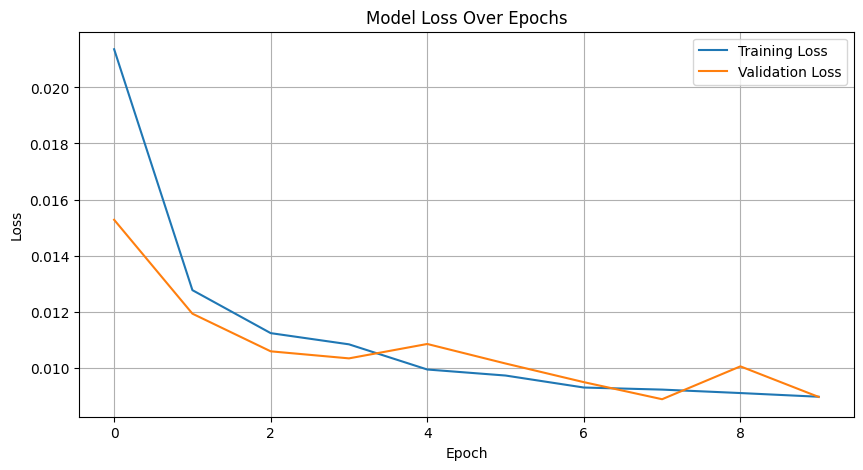

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assume create_model, X_train, y_train, X_test, y_test are already defined

# Create the model
model = create_model(input_shape=X_train.shape[1:])

# Fit the model
history = model.fit(X_trainn, y_trainn, epochs=10, batch_size=32, validation_data=(X_testn, y_testn))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred

NameError: name 'y_pred' is not defined

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame({"MAE": [0.01474, 0.01561], "RMSE": [0.2340, 0.2682]}, index=["LSTM", "GRU"])

,MAE,RMSE
LSTM,0.01474,0.2340
GRU,0.01561,0.2682
